# 3D visualisation of microscopy images

In [1]:
from pathlib import Path

from confocal_microscopy.files import ims
from confocal_microscopy.color import channels
import matplotlib.pyplot as plt
import ipywidgets
from skimage import exposure
import numpy as np
import vtk
from vtk.util import numpy_support as vtk_np
from skimage import io

In [2]:
exposure.equalize_adapthist?

In [3]:
%matplotlib inline

In [4]:
def maximum_intensity_projection(image, axis=0):
    return image.max(axis=axis)

In [5]:
image_path = Path("/home/yngve/Documents/Fish 1 complete/Cancer region/Blood vessels 3d stack/fast_2020-09-02_Federico s_10.41.10_JFM9CC2.ims")

image = ims.load_image_stack(image_path, resolution_level=2)

In [6]:
from skimage import io

In [7]:
io.imsave("image.tiff", image)

<ipython-input-7-5b7e8993b5bd>:1: UserWarning: image.tiff is a low contrast image
  io.imsave("image.tiff", image)


In [8]:
image_path = Path("/home/yngve/Documents/Fish 1 complete/Cancer region/Blood vessels 3d stack/fast_2020-09-02_Federico s_10.41.10_JFM9CC2.ims")

image = ims.load_image_stack(image_path, resolution_level=2)
orig_image = image
image = exposure.equalize_adapthist(image, kernel_size=(100, 100, 20))
image = image.astype(float)
image = np.minimum(image, np.percentile(image, 99.9))
image -= image.min()
image /= image.max()

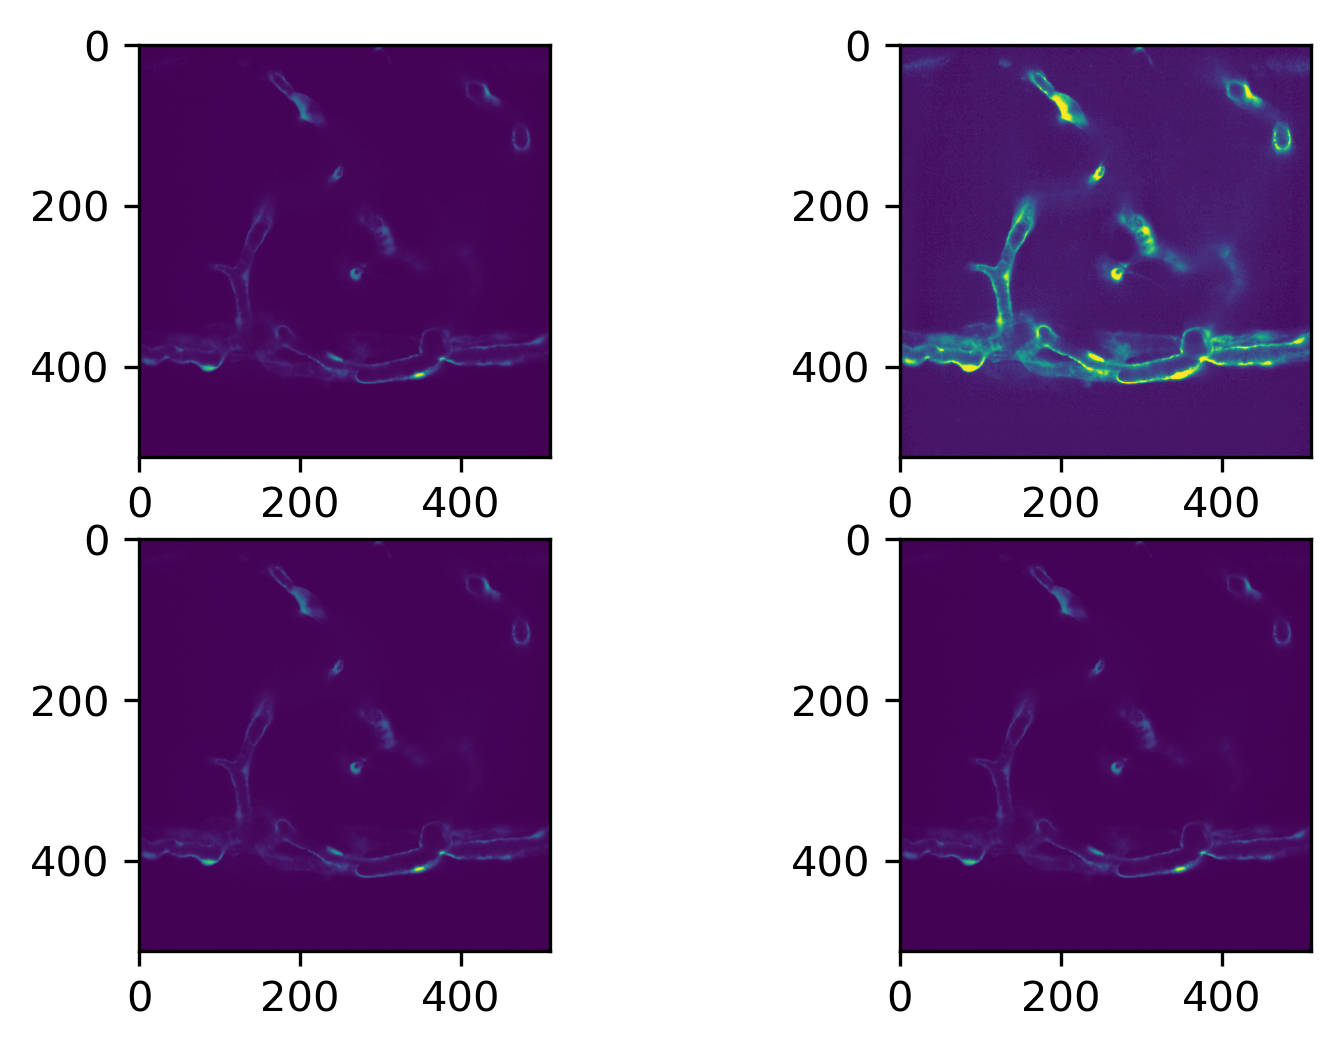

In [9]:
slice_ = 13

plt.figure(dpi=300)
plt.subplot(221)
plt.imshow(orig_image[slice_])
plt.subplot(222)
plt.imshow(image[slice_])
plt.subplot(223)
plt.imshow(image[slice_] + orig_image[slice_])
plt.subplot(224)
plt.imshow(image[slice_] + 10*orig_image[slice_])

In [11]:
from tqdm import trange

conductance = 0.1
stepsize = 0.1
timesteps = 20

def psi(x, conductance):
    return 2*x/(2*(conductance**2) + x**2)

def psi(x, conductance):
    x[np.abs(x) > conductance] = 0
    return x*((1 - (x/conductance)**2)**2)

denoised = image.copy()


def _make_num_borders_array(image):
    ndim = image.ndim
    num_borders = 2*ndim*np.ones_like(image)

    for axis in range(ndim):
        front_slices = [slice(None)]*ndim
        front_slices[axis] = 0
        back_slices = [slice(None)]*ndim
        back_slices[axis] = -1

        num_borders[tuple(front_slices)] -= 1
        num_borders[tuple(back_slices)] -= 1
    
    return num_borders


def anisotropic_diffusion(image, edge_scale, step_size, num_steps, return_copy=True, progress=False):
    if return_copy:
        denoised = image.copy()
    else:
        denoised = image
    
    if progress:
        range_ = trange
    else:
        range_ = range
    
    num_borders = _make_num_borders_array(denoised)
    
    ndim = denoised.ndim
    for i in range_(num_steps):
        diffs = np.zeros_like(denoised)

        for axis in range(ndim):
            forward_slices = [slice(None)]*ndim
            forward_slices[axis] = slice(None, -1, None)
            forward_slices = tuple(forward_slices)

            backward_slices = [slice(None)]*ndim
            backward_slices[axis] = slice(1, None, None)
            backward_slices = tuple(backward_slices)

            reversed_slices = [slice(None)]*ndim
            reversed_slices[axis] = slice(None, None, -1)
            reversed_slices = tuple(reversed_slices)

            diffs[forward_slices] += psi(np.diff(denoised, axis=axis), edge_scale)
            diffs[backward_slices] += psi(np.diff(denoised[reversed_slices], axis=axis)[reversed_slices], edge_scale)

        denoised += step_size*diffs/num_borders
    
    return denoised

denoised = anisotropic_diffusion(image, 0.2, 0.1, 10, progress=True)

100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


In [37]:
io.imsave("denoised.tiff", (denoised*orig_image.max()).astype(orig_image.dtype))

<ipython-input-37-33f65b3c1d86>:1: UserWarning: denoised.tiff is a low contrast image
  io.imsave("denoised.tiff", (denoised*orig_image.max()).astype(orig_image.dtype))


<IPython.core.display.Javascript object>


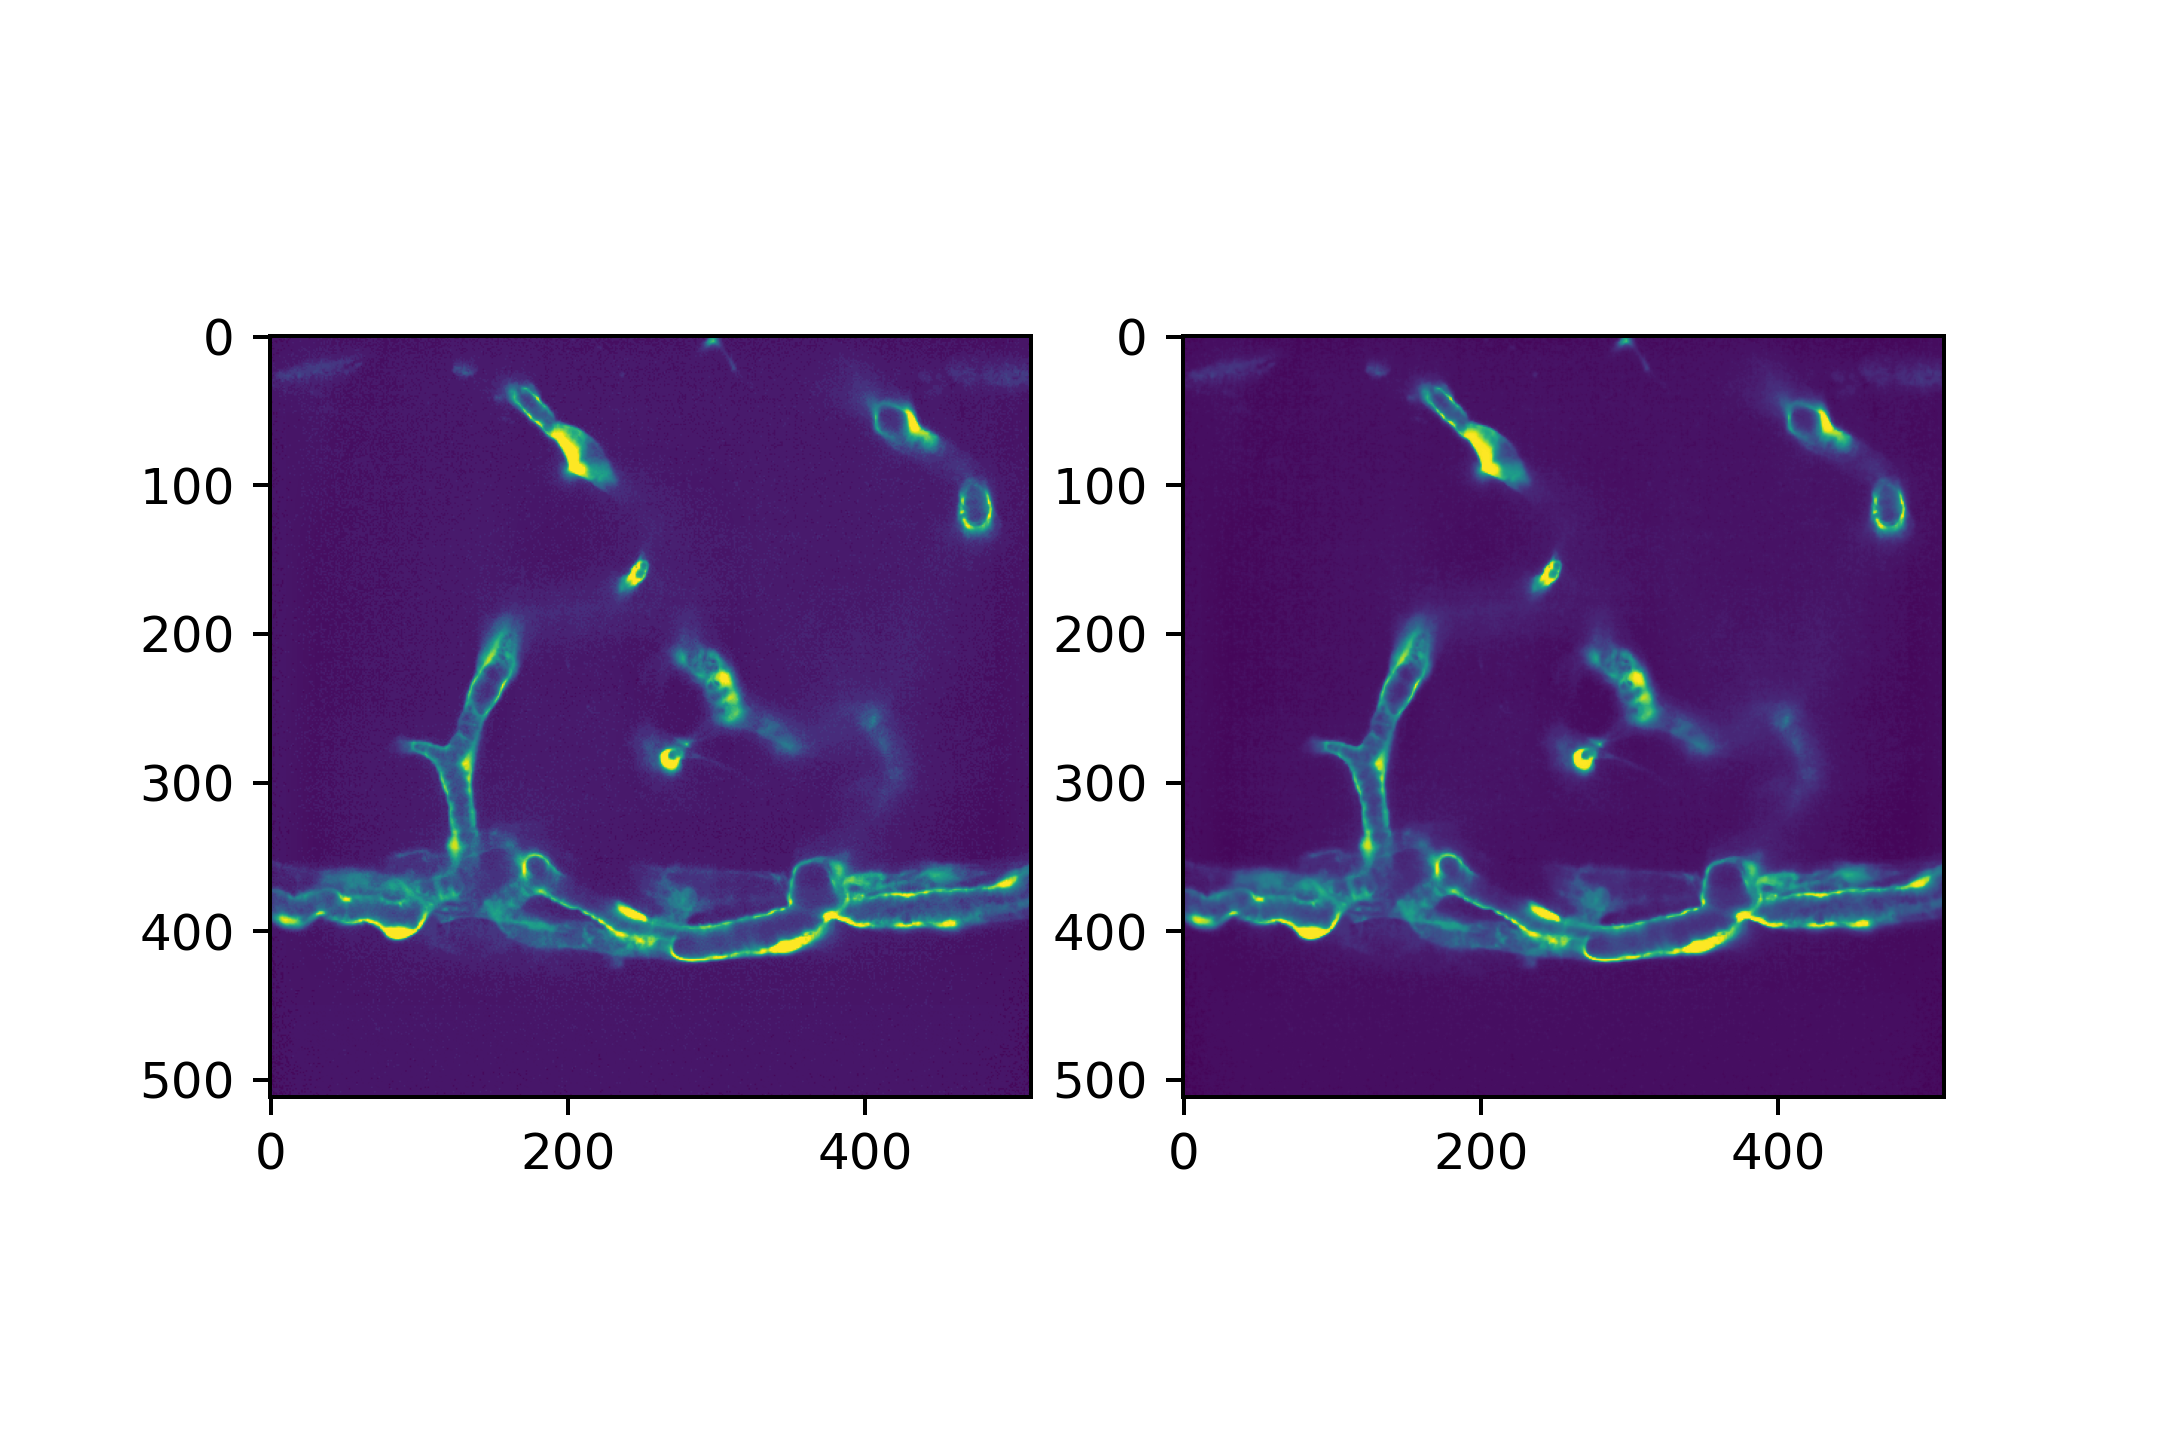

In [38]:
slice_ = 13

plt.figure(dpi=300)
plt.subplot(121)
plt.imshow(image[slice_])
plt.subplot(122)
plt.imshow(denoised[slice_])

In [13]:
from scipy.ndimage import zoom
small = zoom(denoised, 0.3)

In [39]:
import morphsnakes
num_its = 21

it = iter(trange(num_its+1))
def callback(*args):
    next(it)
    

a = morphsnakes.morphological_chan_vese(denoised, iterations=num_its,
                                    init_level_set=denoised > 0.15,
                                    lambda1=1, lambda2=10,   
                                    iter_callback=callback
                                    )


  3%|▎         | 5/151 [35:19<17:11:28, 423.89s/it]

 95%|█████████▌| 21/22 [01:22<00:04,  4.12s/it]

In [35]:
io.imsave("mask.tiff", (a*255).astype(np.uint8))

<IPython.core.display.Javascript object>


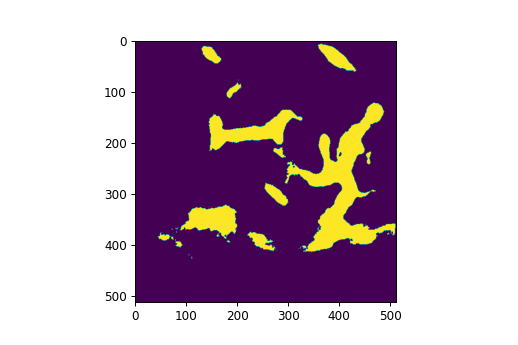

In [44]:
from scipy import ndimage

lab = a
plt.figure()
plt.imshow(denoised[25])
plt.imshow(a[25])
plt.show()

In [45]:
import pyvista as pv

In [62]:
values = denoised
values.shape

# Create the spatial reference
grid = pv.UniformGrid()

# Set the grid dimensions: shape + 1 because we want to inject our values on
#   the CELL data
grid.dimensions = np.array(values.shape) + 1

# Edit the spatial reference
grid.spacing = (5, 1, 1)  # These are the cell sizes along each axis

# Add the data values to the cell data
grid.cell_arrays["values"] = values.flatten(order="F")  # Flatten the array!

# Now plot the grid!
#grid.plot(show_edges=False)


pl = pv.PlotterITK()

In [63]:
pl.add_actor(grid.slice_orthogonal())

In [64]:
pl.show()

Viewer(geometries=[], point_sets=[])

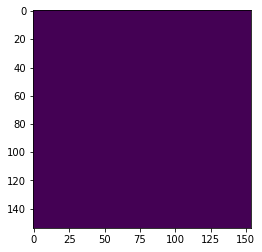

In [165]:
from matplotlib import animation, rc
from IPython.display import HTML

fig, ax = plt.subplots()

imshow = ax.imshow(lab[5])

def init():
    imshow.set_data(lab[0])
    return (imshow,)


def animate(i):
    i = i % lab.shape[0]
    imshow.set_data(lab[i])
    return (imshow,)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=lab.shape[0], interval=500, blit=True)



HTML(anim.to_html5_video())